In [133]:
!pip install piecewise_regression
import pandas as pd
import piecewise_regression
import matplotlib.pyplot as plt
plt.style.use('default')

In [136]:
# Modified versions of the source code in piecewise_regression

import warnings

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

try:
    import piecewise_regression.r_squared_calc as r_squared_calc
    from piecewise_regression.data_validation import (
        validate_positive_number,
        validate_boolean,
        validate_positive_integer,
        validate_list_of_numbers,
        validate_non_negative_integer,
    )
except ImportError:
    import r_squared_calc
    from data_validation import (
        validate_positive_number,
        validate_boolean,
        validate_positive_integer,
        validate_list_of_numbers,
        validate_non_negative_integer,
    )


class NextBreakpoints:
    """
    One iteration of Muggeo's segmented regression algorithm. Gets
    the next breakpoints.
    Also calculates interesting statistics. This expects data validation
    and error
    handling are done at a higher level.

    :param xx: Data series in x-axis for fitting (same axis as the breakpoints)
    :type xx: list

    :param yy: Data series in y-axis for fitting
    :type yy: list

    :param current_breakpoints: The starting breakpoints for this iteration
    :type current_breakpoints: list

    """

    def __init__(
        self,
        # list(float) or numpy(float). REQUIRED. Data series in x-axis
        xx,
        # list(float) or numpy(float). REQUIRED. Data series in y-axis
        yy,
        # list(float) or numpy(float). REQUIRED. Current values of
        # breakpoint positions
        current_breakpoints,
        weights=1.0,
    ):
        # Data validation done at a higher level
        self.xx = xx
        self.yy = yy
        self.current_breakpoints = sorted(current_breakpoints)
        self.n_breakpoints = len(current_breakpoints)

        self.next_breakpoints = None
        self.raw_params = None
        self.covariance_matrix = None

        self.breakpoint_fit(weights)

        # All estimate data saved in dictionary
        self.estimates = {}

        # Don't really need to do this at this point. But it is very quick and
        # nice to have the record of these as we go
        self.calculate_all_estimates()
        self.calculate_all_standard_errors()
        self.calculate_all_confidence_intervals()
        self.calculate_all_t_stats()

        # R squared etc
        self.residual_sum_squares = None
        self.total_sum_squares = None
        self.r_squared = None
        self.adjusted_r_squared = None
        self.bic = None

        self.calculate_r_squared()
        self.calculate_bayesian_information_criterion()

    def breakpoint_fit(self, weights=1.0):
        """
        Fit the linear approximation given the current breakpoint guesses.
        Sets the next breakpoints
        and the params from the fit. The params are of the form [c, a,
        beta_hats, gamma_hats]
        """
        Z = np.array([self.xx])
        # Convert data based on breakpoints

        UU = [
            (self.xx - bp) * np.heaviside(self.xx - bp, 1)
            for bp in self.current_breakpoints
        ]
        VV = [np.heaviside(self.xx - bp, 1) for bp in self.current_breakpoints]

        Z = np.concatenate((Z, UU, VV))
        Z = Z.T
        Z = sm.add_constant(Z, has_constant="add")

        results = sm.WLS(endog=self.yy, exog=Z, weights=weights).fit()

        self.raw_params = results.params
        self.covariance_matrix = results.cov_params()

        # First two params are a and c in the line equation
        # Beta hats are the next group of params, same length as breakpoints
        beta_hats = results.params[2 : 2 + len(self.current_breakpoints)]
        # Gamma hats are the last group of params, same length as breakpoints
        gamma_hats = results.params[2 + len(self.current_breakpoints) :]
        # The next breakpoints are calculated iteratively
        self.next_breakpoints = self.current_breakpoints - gamma_hats / beta_hats

    def calculate_all_estimates(self):
        """
        Extract estiamtes from the params and saves in self.estimates
        """
        params = self.raw_params

        # Extract the exstimates form the correct locations in the params
        const_estimate = params[0]
        beta_estimates = params[2 : self.n_breakpoints + 2]
        breakpoint_estimates = self.next_breakpoints

        self.estimates["const"] = {"estimate": const_estimate}
        for bp_i in range(self.n_breakpoints):
            self.estimates["beta{}".format(bp_i + 1)] = {
                "estimate": beta_estimates[bp_i]
            }
            self.estimates["breakpoint{}".format(bp_i + 1)] = {
                "estimate": breakpoint_estimates[bp_i]
            }
        # Also calculate alphas
        for alpha_i in range(self.n_breakpoints + 1):
            alpha_estimate = np.sum(params[1 : alpha_i + 2])
            self.estimates["alpha{}".format(alpha_i + 1)] = {"estimate": alpha_estimate}

    def get_alpha_standard_errors(self):
        """
        Get the standard errors for the alphas (gradients of segments)
        """
        cov_matrix = self.covariance_matrix

        # Alphas are calculated as the sum of alpha_0 and betas up that part
        # of the regression line
        # The var of each alpha is the sum of the covariance matrix up to it
        # Removing the intercept column and row.
        # var(alpha_k) = var(alpha_1) + sum var(beta_j) +
        #    2*sum_{i=1,j=2}^k *cov(alpha, betas))
        # var(alpha_k) = sum_{i, j} cov(alpha and betas)
        alpha_vars = []
        for alpha_n in range(self.n_breakpoints + 1):
            alpha_cov_matrix = cov_matrix[1 : alpha_n + 2, 1 : alpha_n + 2]
            alpha_vars.append(np.sum(alpha_cov_matrix))

        alpha_ses = np.sqrt(alpha_vars)
        return alpha_ses

    def get_bp_standard_errors(self):
        """
        Get the standard errors of the breakpoints.
        Considering bp = gamma/beta + bp_0, the
        standard error of the breakpoint estaimtes can be found using the
        ratio/delta method.
        See e.g. Muggeo (2003) for clarification
        """
        cov_matrix = self.covariance_matrix
        params = self.raw_params

        bp_vars = []

        # For each breakpoint, calcaulte the variance of the estimator
        for bp_n in range(self.n_breakpoints):
            beta_index = 2 + bp_n
            gamma_index = 2 + self.n_breakpoints + bp_n

            beta = params[beta_index]
            gamma = params[gamma_index]
            gamma_var = cov_matrix[gamma_index, gamma_index]
            beta_var = cov_matrix[beta_index, beta_index]
            gamma_beta_covar = cov_matrix[beta_index, gamma_index]

            # From Muggeo (2003). The sign before the covariance term is
            # opposite to Muggeo, this is because the gamma is defined with
            # the opposite sign
            # The calculation is equivalent to Muggeos.
            bp_var = (
                gamma_var
                + beta_var * (gamma / beta) ** 2
                - 2 * (gamma / beta) * gamma_beta_covar
            ) / (beta**2)
            bp_vars.append(bp_var)

        bp_ses = np.sqrt(bp_vars)
        return bp_ses

    def get_const_standard_error(self):
        """
        Get the constant standard error from the covariance matrix
        """
        # Covariance matrix is [c, alpha, betas, gammas]
        # Constant variance is just the top left cell in covariance matrix
        cov_matrix = self.covariance_matrix
        c_var = cov_matrix[0][0]
        return np.sqrt(c_var)

    def get_beta_standard_errors(self):
        """
        Get the beta estimates standard errors from the covariance matrix
        """
        # Covariance matrix is [c, alpha, betas, gammas]
        # Beta variances are along the diagonal of the covariance matrix
        cov_matrix = self.covariance_matrix
        cov_diagonal = np.diagonal(cov_matrix)
        beta_vars = cov_diagonal[2 : self.n_breakpoints + 2]
        return np.sqrt(beta_vars)

    def calculate_all_standard_errors(self):
        """
        Calculate standard errors for all the variables of interest.
        Save to the self.estimates dictionary
        """
        const_ses = self.get_const_standard_error()
        self.estimates["const"]["se"] = const_ses

        beta_ses = self.get_beta_standard_errors()
        bp_ses = self.get_bp_standard_errors()
        for bp_i in range(self.n_breakpoints):
            self.estimates["beta{}".format(bp_i + 1)]["se"] = beta_ses[bp_i]
            self.estimates["breakpoint{}".format(bp_i + 1)]["se"] = bp_ses[bp_i]
        alpha_ses = self.get_alpha_standard_errors()
        for alpha_i in range(self.n_breakpoints + 1):
            self.estimates["alpha{}".format(alpha_i + 1)]["se"] = alpha_ses[alpha_i]

    def calculate_all_confidence_intervals(self):
        """
        Calculate all confidence intervals, based on t-distribution and
        standard errors.
        """
        # Estimates
        dof = len(self.xx) - 2 - 2 * self.n_breakpoints
        t_const = scipy.stats.t.ppf(0.975, dof)

        # Iterate over the estimate dictionary, add confidence intervals
        # to all estimators
        for estimator_name, details in self.estimates.items():
            confidence_interval = (
                details["estimate"] - t_const * details["se"],
                details["estimate"] + t_const * details["se"],
            )
            details["confidence_interval"] = confidence_interval

    def calculate_all_t_stats(self):
        """
        Get t stats for all the estimators
        """
        dof = len(self.xx) - 2 - 2 * self.n_breakpoints
        for estimator_name, details in self.estimates.items():
            # Breakpoint t stats don't make sense
            # Don't exist in the null model - nuisance parameter
            # H_0 isn't bp=0, it's that bp doesn't exist
            if "breakpoint" in estimator_name:
                details["t_stat"] = "-"
                details["p_t"] = "-"
            else:
                t_stat = details["estimate"] / details["se"]
                p_t = scipy.stats.t.sf(np.abs(t_stat), dof) * 2
                details["t_stat"] = t_stat
                if "beta" in estimator_name:
                    details["p_t"] = "-"
                else:
                    details["p_t"] = p_t

    def get_predicted_yy(self):
        """
        Get the model predictions for each of the xx data points
        """
        params = self.raw_params
        breakpoints = self.next_breakpoints
        # Extract what we need from params etc
        intercept_hat = params[0]
        alpha_hat = params[1]
        beta_hats = params[2 : 2 + len(breakpoints)]

        yy_predicted = []

        yy_predicted = intercept_hat + alpha_hat * self.xx
        for bp_count in range(len(breakpoints)):
            yy_predicted += beta_hats[bp_count] * np.maximum(
                self.xx - breakpoints[bp_count], 0
            )

        return yy_predicted

    def calculate_r_squared(self):
        """
        Calculate R squared from the fitted model.
        """
        yy_predicted = self.get_predicted_yy()
        n_params = 2 * self.n_breakpoints + 2

        rss, tss, r2, adjr2 = r_squared_calc.get_r_squared(
            self.yy, yy_predicted, n_params
        )

        self.residual_sum_squares = rss
        self.total_sum_squares = tss
        self.r_squared = r2
        self.adjusted_r_squared = adjr2

    def calculate_bayesian_information_criterion(self):
        """
        Calculates the Bayesian Information Criterion of the fitted model.
        Assuming normal noise, uses the standard version for OLS models.
        This should hold for breakpoint regression models, because the BIC
        is based on the likelihood of the data
        given the model. That likelihood function doesn't involve the
        breakpoint values - it just depends on distances
        of the data to the fitted model predictions. Also depends on the error
        in the noise term being constant.
        """
        n = len(self.xx)  # No. data points
        k = 2 + 2 * self.n_breakpoints  # No. model parameters
        rss = self.residual_sum_squares
        self.bic = n * np.log(rss / n) + k * np.log(n)


class Muggeo:
    """
    Muggeo's iterative segmented regression method. This is a simple version.
    Errors are handled at a higher level in the Fit object. See Muggeo (2003).
    If the breakpoints get too close together, or get outside
    (or near the edge) of the data range,
    the algorithm is stopped because this is likely to be a local
    minimum that is difficult to escape, as well
    as possibly generating errors in the iterative procedue.

    :param xx: Data series in x-axis for fitting (same axis as the breakpoints)
    :type xx: list of floats

    :param yy: Data series in y-axis for fitting
    :type yy: list of floats

    :param n_breakpoints: The number of breakpoints to fit
    :type n_breakpoints: positive int

    :param start_values: A list of initial guesses for the breakpoints
    :type start_values: list floats

    :param verbose: If True, prints out updates to the terminal
    :type verbose: bool

    :param max_iterations: How many iterations before stopping if not converged
    :type max_iterations: positive int

    :param tolerance: How close breakpoints from pervious iterations must be
        to consider converged.
    :type tolerance: positive float

    :param min_distance_between_breakpoints: The minimum allowed distance
        between breakpoints, as a proportion of the data range.
    :type min_distance_between_breakpoints: positive float

    :param min_distance_between_breakpoints: The minimum allowed distance from
        the edge of data to a breakpoint, as a proportion of the data range.
    :type min_distance_between_breakpoints: positive float

    """

    def __init__(
        self,
        # list(float) or numpy(float). REQUIRED. Data series in x-axis
        xx,
        # list(float) or numpy(float). REQUIRED. Data series in y-axis
        yy,
        n_breakpoints,  # int. REQUIRED. Number of breakpoints
        # list(float) or numpy(float). REQUIRED. Initial guesses for
        # breakpoint positions
        start_values=None,
        # Boolean. whether to print progress to terminal.
        verbose=False,
        max_iterations=30,  # Positive int. Maximum iterations of
        # Muggeo algorithm if not converged
        tolerance=10**-5,  # Positive float. If breakpoints change
        # less than the tolerance then the algorithm has converged
        # Positive float. The minimum required distance between
        # breakpoints, as a proportion of the data range.
        min_distance_between_breakpoints=0.01,
        # Positive float. Minimum distance from edge of data to a
        # breakpoint, as a proportion of the data range.
        min_distance_to_edge=0.02,
        weights=1.0,
    ):
        self.verbose = verbose
        if self.verbose:
            print(
                "\nInstantiating Muggeo . . . with start_values = {}".format(
                    start_values
                )
            )
        self.weights = weights

        # validation is done at a higher level
        self.xx = xx
        self.yy = yy

        self.n_breakpoints = n_breakpoints
        self.min_distance_between_breakpoints = min_distance_between_breakpoints
        self.min_distance_to_edge = min_distance_to_edge

        if start_values is None:
            start_values = self._generate_breakpoints()

        self.start_values = self._validate_start_values(start_values)

        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.verbose = verbose

        self.stop = False

        if self.n_breakpoints != len(self.start_values):
            raise ValueError(
                "n_breakpoints is not the same as the length of start_values"
            )

        self.fit_history = []
        self.best_fit = None
        self.converged = False

        # Records the reason why the algorithm stopped
        self.stop_reason = None

        self.fit()

    def fit(self):
        """
        Runs the breakpoint iterative procedure
        """
        if self.verbose:
            print("Running Muggeo's iterative algorithm . . . ")
        while not self.stop:
            # Do the fit
            # Get the current breakpoints. If first fit then use start_vakues,
            # otherwise use fit history
            if len(self.fit_history) == 0:
                current_breakpoints = self.start_values
            else:
                current_breakpoints = self.fit_history[-1].next_breakpoints

            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    IteratedFit = NextBreakpoints(
                        self.xx, self.yy, current_breakpoints, weights=self.weights
                    )
                    self.fit_history.append(IteratedFit)
                    self.stop_or_not()
                    if self.verbose:
                        print("Next breakpoints are ", IteratedFit.next_breakpoints)
            except Exception as e:
                self.stop = True
                self.stop_reason = "Error encountered: " + str(e)

        # Select the best fit from the fit history by finding the smallest rss
        if len(self.fit_history) > 0:
            self.best_fit = min(self.fit_history, key=lambda x: x.residual_sum_squares)

    def stop_or_not(self):
        """
        Test to see if the iterative procedure should stop.
        Stop if it's converged, if max_iterations reached, of the breakpoints
        fall into values that
        are too close together or outside of the allowed rance.
        """
        # Stop if maximum iterations reached
        if len(self.fit_history) > self.max_iterations:
            self.stop_reason = "Algorithm stopped as max iterations reached"
            self.stop = True

        if not self._are_breakpoint_values_far_apart(
            self.fit_history[-1].next_breakpoints
        ):
            self.stop_reason = "Breakpoint values too close together"
            self.stop = True

        if not self._are_breakpoint_values_within_range(
            self.fit_history[-1].next_breakpoints
        ):
            self.stop_reason = "Breakpoint values outside range"
            self.stop = True

        # Stop if tolerance reached - small change between this and last
        # breakpoints
        if len(self.fit_history) > 1:
            breakpoint_differences = (
                self.fit_history[-2].next_breakpoints
                - self.fit_history[-1].next_breakpoints
            )
            if np.max(np.abs(breakpoint_differences)) <= self.tolerance:
                self.stop_reason = "Algorithm converged on breakpoint values"
                self.stop = True
                self.converged = True

        # Stop if the algorithm is iterating back to previous values, within
        # tolerance
        if len(self.fit_history) > 2:
            breakpoint_two_step_differences = (
                self.fit_history[-3].next_breakpoints
                - self.fit_history[-1].next_breakpoints
            )
            if np.max(np.abs(breakpoint_two_step_differences)) <= self.tolerance:
                self.stop_reason = "Algorithm converged on breakpoint values"
                self.stop = True
                self.converged = True

    def _validate_start_values(self, start_values):
        """
        Validate the breakpoint start_values.
        Should be a list of numbers, or a numpy list of numbers.
        They should also be not too close to the edge of the data, and not too
        close together - to avoid the Muggeo algorithm diverging

        :param start_values: A list of initial guesses for the breakpoints
        :type start_values: list floats

        """

        start_values = validate_list_of_numbers(
            start_values, "start_values", min_length=1
        )

        if not self._are_breakpoint_values_within_range(start_values):
            self.stop = True
            self.stop_reason = (
                "start_values are not within allowed range."
                "Try changing min_distance_to_edge"
            )

        if not self._are_breakpoint_values_far_apart(start_values):
            self.stop = True
            self.stop_reason = (
                "start_values are too close together."
                "Try changing "
                "min_distance_between_breakpoints"
            )
        return start_values

    def _are_breakpoint_values_within_range(self, breakpoints):
        """
        Check that breakpoints are self.min_distance_to_edge * range away for
        the edge of the data in x

        :param breakpoints: A list of breakpoints
        :type breakpoints: list floats

        """
        min_allowed_bp = np.quantile(self.xx, self.min_distance_to_edge)
        max_allowed_bp = np.quantile(self.xx, 1 - self.min_distance_to_edge)

        for bp in breakpoints:
            if bp <= min_allowed_bp or bp >= max_allowed_bp:
                return False
        return True

    def _are_breakpoint_values_far_apart(self, breakpoints):
        """
        Check if breakpoint values are
        self.min_distance_between_breakpoints*range away from each other

        :param breakpoints: A list of breakpoints
        :type breakpoints: list floats

        """
        min_distance = np.diff(np.sort(breakpoints))

        # numpy ptp gives the range of the data, closeness relative to that
        min_distance_allowed = self.min_distance_between_breakpoints * np.ptp(self.xx)

        if (min_distance <= min_distance_allowed).any():
            return False
        return True

    def _generate_breakpoints(self):
        """
        Randomly generate some breakpoint values
        """
        # Get breakpoints within allowed range
        min_allowed_bp = np.quantile(self.xx, self.min_distance_to_edge)
        max_allowed_bp = np.quantile(self.xx, 1 - self.min_distance_to_edge)
        start_values = np.random.uniform(
            low=min_allowed_bp, high=max_allowed_bp, size=self.n_breakpoints
        )
        if self.verbose:
            print("Generating some random breakpoints: ", start_values)
        return sorted(start_values)


class Fit:
    """
    Fit a peicewise (segmented) regression model to data.
    Uses bootstrap restarting to avoid local minima.
    Requires either n_breakpoints of start_values.
    if no start_vaues are given, they are instead uniformly randomly
    generated across range of data.
    This is the main user facing object and input data is validated mainly
    at this level.

    :param xx: Data series in x-axis for fitting (same axis as the breakpoints)
    :type xx: list of floats

    :param yy: Data series in y-axis for fitting.
    :type yy: list of floats

    :param n_breakpoints: The number of breakpoints to fit.
    :type n_breakpoints: positive int

    :param start_values: A list of initial guesses for the breakpoints.
    :type start_values: list floats

    :param n_boot: How many times to run the bootstrap restarting procedure.
        Set to zero for no bootstrap restarting.
    :type n_boot: non-negative int

    :param verbose: If True, prints out updates to the terminal.
    :type verbose: bool

    :param max_iterations: How many iterations before stopping if not
        converged, in the Muggeo iterative procedure.
    :type max_iterations: positive int

    :param tolerance: How close breakpoints from pervious iterations must
        be to consider converged.
    :type tolerance: positive float

    :param min_distance_between_breakpoints: The minimum allowed distance
        between breakpoints, as a proportion of the data range.
    :type min_distance_between_breakpoints: positive float

    :param min_distance_between_breakpoints: The minimum allowed distance from
        the edge of data to a breakpoint, as a proportion of the data range.
    :type min_distance_between_breakpoints: positive float

    """

    def __init__(
        self,
        # list(float) or numpy(float). REQUIRED Data series in x-axis
        xx,
        # list(float) or numpy(float). REQUIRED Data series in y-axis
        yy,
        # list(float) or numpy(float). Initial guesses for breakpoint
        # positions
        start_values=None,
        # int. If not start_values, the number of breakpoints to fit.
        # REQUIRED if no start_values
        n_breakpoints=None,
        n_boot=100,  # Positive int. The number of times to run the
        # bootstrap restarting. n_boot=0 runs the Muggeo algorithm
        # with no bootstrap
        # Boolean. whether to print progress to terminal.
        verbose=False,
        max_iterations=30,  # Positive int. Maximum iterations of
        # Muggeo algorithm if not converged
        tolerance=10**-5,  # Positive float. If breakpoints change
        # less than the tolerance then the algorithm has converged
        # Positive float. The minimum required distance between
        # breakpoints, as a proportion of the data range.
        min_distance_between_breakpoints=0.01,
        # Positive float. Minimum distance from edge of data to a
        # breakpoint, as a proportion of the data range.
        min_distance_to_edge=0.02,
        weights=weights,
    ):
        self.verbose = validate_boolean(verbose, "verbose")

        if self.verbose:
            print("\nInstantiating Fit . . . ")

        self.weights = weights
        # Validate all input data
        self.xx = validate_list_of_numbers(xx, "xx", min_length=3)
        self.yy = validate_list_of_numbers(yy, "yy", min_length=3)

        if len(self.yy) != len(self.xx):
            raise ValueError("x and y data series must be the same size")

        self.n_boot = validate_non_negative_integer(n_boot, "n_boot")
        self.max_iterations = validate_positive_integer(
            max_iterations, "max_iterations"
        )
        self.tolerance = validate_positive_number(tolerance, "tolerance")
        self.min_distance_between_breakpoints = validate_positive_number(
            min_distance_between_breakpoints, "min_distance_between_breakpoints"
        )
        self.min_distance_to_edge = validate_positive_number(
            min_distance_to_edge, "min_distance_to_edge"
        )

        # We need either start_values or n_breakpoints
        if n_breakpoints is None:
            self.n_breakpoints = None
        else:
            self.n_breakpoints = validate_positive_integer(
                n_breakpoints, "n_breakpoints"
            )

        if start_values is None:
            self.start_values = None
        else:
            self.start_values = validate_list_of_numbers(
                start_values, "start_values", min_length=1
            )
            self.n_breakpoints = len(self.start_values)

        if start_values is None and n_breakpoints is None:
            raise ValueError(
                "Fit algorithm requires either start_values or n_breakpoints"
            )

        self.bootstrap_history = []
        self.best_muggeo = None
        self.stop = False

        self.bootstrap_restarting()

    def get_results(self):
        """
        Return a small dictionary with key results form the fit.
        Useful for using this code in a larger analysis. E.g. ModelSelection
        """
        results = {}

        if self.best_muggeo:
            results["estimates"] = self.best_muggeo.best_fit.estimates
            results["bic"] = self.best_muggeo.best_fit.bic
            results["rss"] = self.best_muggeo.best_fit.residual_sum_squares
            results["converged"] = True
        else:
            results["converged"] = False
            results["estimates"] = None
            results["bic"] = None
            results["rss"] = None
        return results

    def bootstrap_restarting(self):
        """
        The main fitting algorithm. Begins by doing a fit based on
        Muggeo's algorithm.
        if n_boot = 0 we stop there. Otherwise we do some bootstrap restarting.
        Bootstrap Restarting escapes local minima.
        Each bootstrap restart:
        - We take the best current breakpoints, and get new data by running a
            non-parametric bootstrap by resampling data.
        - Then run a Muggeo fit on the new data and best current breakpoints.
            This gives new breakpoint values.
        - Then run a Muggeo fit again with the original data and these new
            breakpoint values.
        - Throughout, keep track of the history of fits and the best_muggeo
            fit that converged - defined as the lowest residual sum of squares.
        """
        min_d_between_bps = self.min_distance_between_breakpoints
        muggeo_fit = Muggeo(
            xx=self.xx,
            yy=self.yy,
            start_values=self.start_values,
            n_breakpoints=self.n_breakpoints,
            max_iterations=self.max_iterations,
            tolerance=self.tolerance,
            verbose=self.verbose,
            min_distance_between_breakpoints=min_d_between_bps,
            min_distance_to_edge=self.min_distance_to_edge,
            weights=self.weights,
        )

        self.bootstrap_history.append(muggeo_fit)

        # best_muggeo is the best converged muggeo
        if muggeo_fit.converged:
            self.best_muggeo = muggeo_fit

        # Iterate bootstraps
        for i in range(self.n_boot):
            # Best breakpoints are either from best converged muggeo so far,
            # or start values, or randomly generated
            if self.best_muggeo and np.random.uniform() < 0.5:
                best_bps = self.best_muggeo.best_fit.next_breakpoints
            else:
                best_bps = self.start_values

            # Get some new breakpoint values from a bootstrapped fit
            # Non parametric bootstrap by resampling from data
            xx_boot, yy_boot = self.bootstrap_data(self.xx, self.yy)
            bootstrap_fit = Muggeo(
                xx_boot,
                yy_boot,
                start_values=best_bps,
                n_breakpoints=self.n_breakpoints,
                max_iterations=self.max_iterations,
                tolerance=self.tolerance,
                verbose=self.verbose,
                min_distance_between_breakpoints=min_d_between_bps,
                min_distance_to_edge=self.min_distance_to_edge,
                weights=self.weights,
            )
            if bootstrap_fit.converged:
                bootstrap_bps = bootstrap_fit.best_fit.next_breakpoints
            else:
                # Give it something - even though these breakpoints are
                # already run
                # prefer this to using breaks in the for loop
                bootstrap_bps = best_bps

            # Do a new fit with the new breakpoint values
            next_muggeo = Muggeo(
                self.xx,
                self.yy,
                start_values=bootstrap_bps,
                n_breakpoints=self.n_breakpoints,
                max_iterations=self.max_iterations,
                tolerance=self.tolerance,
                verbose=self.verbose,
                min_distance_between_breakpoints=min_d_between_bps,
                min_distance_to_edge=self.min_distance_to_edge,
                weights=self.weights,
            )
            self.bootstrap_history.append(next_muggeo)

            # If we get a converged answer, see if this new fit is the best
            if next_muggeo.converged:
                # If there is already a converged best_muggeo, see if this one
                # is better
                if self.best_muggeo:
                    if (
                        next_muggeo.best_fit.residual_sum_squares
                        < self.best_muggeo.best_fit.residual_sum_squares
                    ):
                        self.best_muggeo = next_muggeo
                # If there is not already a converged best_muggeo, use this
                # fit instead
                else:
                    self.best_muggeo = next_muggeo

    def bootstrap_data(self, xx, yy):
        """
        Non parametric bootstrap, randomly sample data points with replacement.
        Return bootstrapped data of same length as oriignal data.

        :param xx: Data series in x-axis.
        :type xx: list of floats

        :param yy: Data series in y-axis.
        :type yy: list of floats

        """
        n = len(xx)
        # Get bootstrap samples as array index locations
        boot_indices = np.random.choice(n, size=n, replace=True)

        xx_boot = xx[boot_indices]
        yy_boot = yy[boot_indices]
        return xx_boot, yy_boot

    def plot_data(self, **kwargs):
        """
        Plot the data as a scatter plot.
        Passes any kwargs to the matplotlib scatter function, e.g. color="red".

        """
        plt.scatter(self.xx, self.yy, **kwargs)

    def plot_fit(self, **kwargs):
        """
        Plot the fitted model as a series of straight lines.
        Passes any kwargs to the matplotlib plot function, e.g. color="red".

        """
        if not self.best_muggeo:
            print("Algorithm didn't converge. No fit to plot.")
        else:
            # Get the final results from the fitted model variables
            # Params are in terms of [intercept, alpha, betas, gammas]
            final_params = self.best_muggeo.best_fit.raw_params
            breakpoints = self.best_muggeo.best_fit.next_breakpoints

            # Extract what we need from params etc
            intercept_hat = final_params[0]
            alpha_hat = final_params[1]
            beta_hats = final_params[2 : 2 + len(breakpoints)]

            xx_plot = np.linspace(min(self.xx), max(self.xx), 100)

            # Build the fit plot segment by segment. Betas are defined as
            # difference in gradient from previous section
            yy_plot = intercept_hat + alpha_hat * xx_plot
            for bp_count in range(len(breakpoints)):
                yy_plot += beta_hats[bp_count] * np.maximum(
                    xx_plot - breakpoints[bp_count], 0
                )

            plt.plot(xx_plot, yy_plot, **kwargs)

    def plot_breakpoints(self, **kwargs):
        """
        Plot the breakpoint locations as vertical lines.
        Passes kwargs to the matplotlib function, e.g. color="red".

        """
        if not self.best_muggeo:
            print("Algorithm didn't converge. No breakpoints to plot")
        else:
            breakpoints = self.best_muggeo.best_fit.next_breakpoints

            for bp in breakpoints:
                plt.axvline(bp, **kwargs)

    def plot_breakpoint_confidence_intervals(self, **kwargs):
        """
        Plot the breakpoint confidence intervals as vertical shaded regions.
        Passes kwargs to the matplotlib function, e.g. color="red".

        """

        if not self.best_muggeo:
            print("Algorithm didn't converge. No breakpoint estimates to plot")
        else:
            estimates = self.best_muggeo.best_fit.estimates

            for bp_i in range(self.best_muggeo.n_breakpoints):
                bp_ci = estimates["breakpoint{}".format(bp_i + 1)][
                    "confidence_interval"
                ]
                plt.axvspan(bp_ci[0], bp_ci[1], alpha=0.1)

    def plot_best_muggeo_breakpoint_history(self, **kwargs):
        """
        Plot the history of the breakpoints as they iterate.
        History of the best_muggeo fit.

        """
        if not self.best_muggeo:
            print("Algorithm didn't converge. No meaningful history to plot")
        else:
            # Get the data from the best_muggeo in a form for plotting
            breakpoint_history = [self.best_muggeo.start_values]
            for fit_details in self.best_muggeo.fit_history:
                breakpoint_history.append(fit_details.next_breakpoints)
            breakpoint_history_series = zip(*breakpoint_history)

            # Plot a history for each breakpoint
            count = 0
            for bh in breakpoint_history_series:
                count += 1
                plt.plot(
                    range(0, len(bh)), bh, label="Breakpoint {}".format(count), **kwargs
                )
                plt.xlabel("Muggeo Iteration")
                plt.ylabel("Breakpoint")

    def plot_bootstrap_restarting_history(self, **kwargs):
        """
        Plot the history of the breakpoint values as they iterate.
        History of the bootstrap restarting procedure.

        """
        if not self.best_muggeo:
            print("Algorithm didn't converge. Plotting breakpoint history")

        # Get the data from the best_muggeo in a form for plotting

        breakpoint_history = [self.start_values]

        for muggeo_fit in self.bootstrap_history:
            if muggeo_fit.best_fit:
                breakpoint_history.append(muggeo_fit.best_fit.next_breakpoints)
            else:
                breakpoint_history.append(None)

        breakpoint_history_series = zip(*breakpoint_history)

        # Plot a history for each breakpoint
        count = 0
        for bh in breakpoint_history_series:
            count += 1
            plt.plot(
                range(0, len(bh)), bh, label="Breakpoint {}".format(count), **kwargs
            )
            plt.xlabel("Bootstrap Iteration")
            plt.ylabel("Breakpoint")

    def plot_bootstrap_restarting_rss_history(self, **kwargs):
        """
        Plot the history of the residual sum of squares.
        History of the bootstrap restarting algorithm.

        """
        if not self.best_muggeo:
            print("Algorithm didn't converge. Plotting rss history anyway")

        # Get the data from the best_muggeo in a form for plotting

        rss_history = []

        for muggeo_fit in self.bootstrap_history:
            if muggeo_fit.best_fit:
                rss_history.append(muggeo_fit.best_fit.residual_sum_squares)
            else:
                rss_history.append(None)

        plt.plot(range(1, len(rss_history) + 1), rss_history, **kwargs)
        plt.xlabel("Bootstrap Iteration")
        plt.ylabel("Residual Sum of Squares")

    def plot(self):
        """
        Plot the full fit including the data, fitted model, breakpoint
        positions and breakpoint confidence intervals.
        Doesn't allow control of matplotlib kwargs for style changes.
        """
        self.plot_data()
        self.plot_fit()
        self.plot_breakpoints()
        self.plot_breakpoint_confidence_intervals()

    def summary(self):
        """
        Print a summary of the best fit, along the lines of the summary
        given by python's statsmodels OLS fit.
        """

        if not self.best_muggeo:
            summary = (
                "Algorithm did not converge. Try different n_breakpoints, "
                "different start_values, or start_values=None\n"
            )

            summary += "Summary of why the algorithm did not converge:\n"
            run_count = 1
            for muggeo_fit in self.bootstrap_history:
                summary += "Run {}: {} \n".format(run_count, muggeo_fit.stop_reason)
                run_count += 1
            print(summary)

            return summary

        else:
            header = "\n{:^70}\n".format("Breakpoint Regression Results")

            line_length = 100
            double_line = "=" * line_length + "\n"
            single_line = "-" * line_length + "\n"

            # Overview
            n_obs = len(self.xx)
            n_model_params = 2 + 2 * self.n_breakpoints
            dof = n_obs - n_model_params
            no_obs_text = "{:<20} {:>20}\n".format("No. Observations", n_obs)
            no_model_parameters_text = "{:<20} {:>20}\n".format(
                "No. Model Parameters", n_model_params
            )
            dof_text = "{:<20} {:>20}\n".format("Degrees of Freedom", dof)
            rss_text = "{:<20} {:>20.6}\n".format(
                "Res. Sum of Squares", self.best_muggeo.best_fit.residual_sum_squares
            )
            tss_text = "{:<20} {:>20.6}\n".format(
                "Total Sum of Squares", self.best_muggeo.best_fit.total_sum_squares
            )
            r_2_text = "{:<20} {:>20.6f}\n".format(
                "R Squared", self.best_muggeo.best_fit.r_squared
            )
            adj_r_2_text = "{:<20} {:>20.6f}\n".format(
                "Adjusted R Squared", self.best_muggeo.best_fit.adjusted_r_squared
            )
            converged_text = "{:<20} {:>20s}\n".format(
                "Converged: ", str(self.best_muggeo.converged)
            )

            overview = (
                double_line
                + no_obs_text
                + no_model_parameters_text
                + dof_text
                + rss_text
                + tss_text
                + r_2_text
                + adj_r_2_text
                + converged_text
                + double_line
            )

            # Table of results
            table_header_template = (
                "{:<15} {:>12} {:>12} {:>12} " "{:>12} {:>12} {:>12}\n"
            )

            table_header = table_header_template.format(
                "", "Estimate", "Std Err", "t", "P>|t|", "[0.025", "0.975]"
            )

            table_row_template = (
                "{:<15} {:>12.6} {:>12.3} {:>12.5} " " {:>12.3} {:>12.5} {:>12.5}\n"
            )

            table_contents = ""

            beta_names = ["beta{}".format(i + 1) for i in range(self.n_breakpoints)]
            bp_names = ["breakpoint{}".format(i + 1) for i in range(self.n_breakpoints)]

            model_estimator_names = ["const", "alpha1"] + beta_names + bp_names

            estimates = self.best_muggeo.best_fit.estimates

            for est_name in model_estimator_names:
                estimator_row = table_row_template.format(
                    est_name,
                    estimates[est_name]["estimate"],
                    estimates[est_name]["se"],
                    estimates[est_name]["t_stat"],
                    estimates[est_name]["p_t"],
                    estimates[est_name]["confidence_interval"][0],
                    estimates[est_name]["confidence_interval"][1],
                )
                table_contents += estimator_row

            table_contents += single_line

            table_contents += (
                "These alphas(gradients of segments) are estimated"
                "from betas(change in gradient)\n"
            )

            alpha_names = [
                "alpha{}".format(alpha_i + 1)
                for alpha_i in range(1, self.n_breakpoints + 1)
            ]

            table_contents += single_line

            for est_name in alpha_names:
                estimator_row = table_row_template.format(
                    est_name,
                    estimates[est_name]["estimate"],
                    estimates[est_name]["se"],
                    estimates[est_name]["t_stat"],
                    estimates[est_name]["p_t"],
                    estimates[est_name]["confidence_interval"][0],
                    estimates[est_name]["confidence_interval"][1],
                )
                table_contents += estimator_row

            table_contents += double_line

            table = double_line + table_header + single_line + table_contents

            summary = header + overview + table + "\n\n"

            print(summary)

            return summary


if __name__ == "__main__":
    pass

In [137]:
import numpy as np
import statsmodels.api as sm

try:
    import piecewise_regression.r_squared_calc as r_squared_calc
except ImportError:
    import r_squared_calc


class ModelSelection:
    """
    Experimental - uses simple BIC based on simple linear model.
    """

    def __init__(
        self,
        xx,
        yy,
        max_breakpoints=10,
        n_boot=100,
        max_iterations=30,
        tolerance=10**-5,
        min_distance_between_breakpoints=0.01,
        min_distance_to_edge=0.02,
        weights=1.0,
        verbose=True,
    ):
        # The actual fit model objects
        self.models = []
        # The model summary data
        self.model_summaries = []

        self.stop = False

        if verbose:
            print("Running fit with n_breakpoint = 0 . . ")

        self.no_breakpoint_fit(xx, yy, weights)

        min_d_between_bps = min_distance_between_breakpoints
        for k in range(1, max_breakpoints + 1):
            if verbose:
                print("Running fit with n_breakpoint = {} . . ".format(k))
            bootstrapped_fit = Fit(
                xx,
                yy,
                n_breakpoints=k,
                verbose=False,
                n_boot=n_boot,
                max_iterations=max_iterations,
                tolerance=tolerance,
                min_distance_between_breakpoints=min_d_between_bps,
                min_distance_to_edge=min_distance_to_edge,
            )
            fit_summary = bootstrapped_fit.get_results()
            fit_summary["n_breakpoints"] = k
            self.model_summaries.append(fit_summary)
            self.models.append(bootstrapped_fit)

        self.summary()

    def summary(self):
        header = "\n{:^70}\n".format("Breakpoint Model Comparision Results")

        line_length = 100
        double_line = "=" * line_length + "\n"
        single_line = "-" * line_length + "\n"

        table_header_template = "{:<15} {:>12} {:>12} {:>12} \n"
        table_header = table_header_template.format(
            "n_breakpoints", "BIC", "converged", "RSS"
        )
        table_row_template = "{:<15} {:>12.5} {:>12} {:>12.5} \n"

        table_contents = header
        table_contents += double_line

        table_contents += table_header
        table_contents += single_line

        for model_summary in self.model_summaries:
            if model_summary["converged"]:
                model_row = table_row_template.format(
                    model_summary["n_breakpoints"],
                    model_summary["bic"],
                    str(model_summary["converged"]),
                    model_summary["rss"],
                )
            else:
                model_row = table_row_template.format(
                    model_summary["n_breakpoints"],
                    "",
                    str(model_summary["converged"]),
                    "",
                )

            table_contents += model_row

        print(table_contents)

        print("Min BIC (Bayesian Information Criterion) suggests best model")

    def no_breakpoint_fit(self, xx, yy, weights):
        Z = np.array([xx])
        Z = Z.T
        Z = sm.add_constant(Z, has_constant="add")
        # Basic OLS fit
        results = sm.WLS(endog=np.array(yy), exog=Z, weights=weights).fit()

        # get the predicted values
        ff = [(results.params[0] + results.params[1] * x) for x in xx]

        # Get Rss
        rss, tss, r_2, adjusted_r_2 = r_squared_calc.get_r_squared(yy, ff, n_params=2)

        # Calcualte BIC
        n = len(xx)  # No. data points
        k = 2  # No. parameters
        bic = n * np.log(rss / n) + k * np.log(n)

        fit_data = {
            "bic": bic,
            "n_breakpoints": 0,
            "estimates": {},
            "converged": True,
            "rss": rss,
        }

        fit_data["estimates"]["const"] = results.params[0]
        fit_data["estimates"]["alpha1"] = results.params[1]

        self.model_summaries.append(fit_data)


if __name__ == "__main__":
    pass

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     64.975         True       556.66 
1                     57.491         True       256.82 
2                     56.698         True       175.64 

Min BIC (Bayesian Information Criterion) suggests best model
The best number of breakpoints according to BIC is 2

                    Breakpoint Regression Results                     
No. Observations                       17
No. Model Parameters                    6
Degrees of Freedom                     11
Res. Sum of Squares               262.301
Total Sum of Squares              628.672
R Squared                        0.582769
Adjusted R Squared               0.332431
Conve

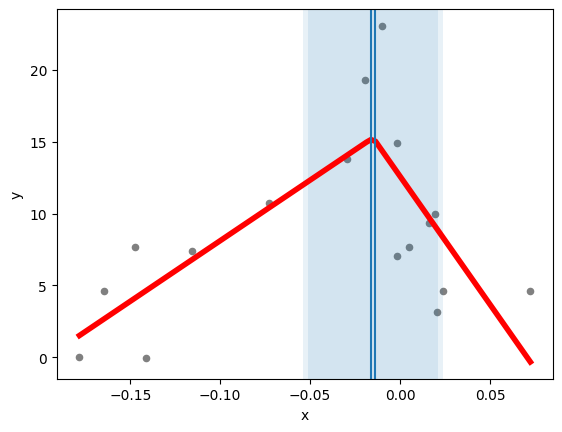

In [156]:
# data from my ACS Catal paper
data = pd.read_csv("data.csv", sep=";", decimal=",", header=None, names=["x", "y"])
data["x"]
ms = piecewise_regression.ModelSelection(
    data["x"].values, data["y"].values, max_breakpoints=2, max_iterations=100
)

# Grab best n from modelselection
bic_list = np.array([summary["bic"] for summary in ms.model_summaries], dtype=float)
n_list = np.array(
    [summary["n_breakpoints"] for summary in ms.model_summaries], dtype=int
)
filter_nan = ~np.isnan(bic_list)
bic_list = bic_list[filter_nan]
n_list = n_list[filter_nan]
n = int(n_list[np.argmin(bic_list)])
print(f"The best number of breakpoints according to BIC is {n}")

# Fit piecewise regression!
pw_fit = piecewise_regression.Fit(data["x"].values, data["y"].values, n_breakpoints=n)
pw_fit.summary()
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     84.241         True       1728.9 
1                     60.159         True       300.47 
2                     67.631         True       334.13 

Min BIC (Bayesian Information Criterion) suggests best model
The best number of breakpoints according to BIC is 1

                    Breakpoint Regression Results                     
No. Observations                       17
No. Model Parameters                    4
Degrees of Freedom                     13
Res. Sum of Squares               312.638
Total Sum of Squares              628.672
R Squared                        0.502700
Adjusted R Squared               0.336933
Conve

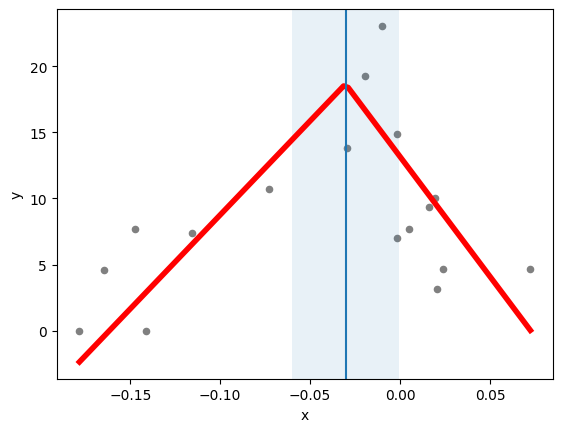

In [157]:
# data from my ACS Catal paper
data = pd.read_csv("data.csv", sep=";", decimal=",", header=None, names=["x", "y"])
data["x"]


# This is a modified example.
# ModelSelection and Fit classes are taken from the cells above
# instead of from piecewise_regression (hence they are simple called "Fit" and "ModelSelection")

# Weights! Current version uses square of y as weight
norm = sum(data["y"])
weights = np.array([abs(py) ** 3 for py in data["y"]])
for y, w in zip(data["y"], weights):
    # print(y,w)
    continue

ms = ModelSelection(
    data["x"].values,
    data["y"].values,
    max_breakpoints=2,
    max_iterations=100,
    weights=weights,
)

# Grab best n from modelselection
bic_list = np.array([summary["bic"] for summary in ms.model_summaries], dtype=float)
n_list = np.array(
    [summary["n_breakpoints"] for summary in ms.model_summaries], dtype=int
)
filter_nan = ~np.isnan(bic_list)
bic_list = bic_list[filter_nan]
n_list = n_list[filter_nan]
n = int(n_list[np.argmin(bic_list)])
print(f"The best number of breakpoints according to BIC is {n}")

# Fit piecewise regression!
pw_fit = piecewise_regression.Fit(data["x"].values, data["y"].values, n_breakpoints=n)
pw_fit.summary()
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

# Case 2

In [10]:
df1 = pd.read_csv('j.nanoen.2019.01.017_2.csv',header=None, names=["x", "y"])
df1

,x,y
0,-0.166671,0.053066
1,-0.124244,0.114045
2,-0.087529,0.137409
3,-0.026297,0.152357
4,0.003855,0.167072
5,0.047308,0.137482
6,0.109296,0.105741
7,0.137786,0.090193
8,0.134256,0.086300
9,0.211377,0.072508


In [11]:
#y = df1['Y'].values
#x = df1['X'].values

In [12]:
df1['x'] 

0   -0.166671
1   -0.124244
2   -0.087529
3   -0.026297
4    0.003855
5    0.047308
6    0.109296
7    0.137786
8    0.134256
9    0.211377
Name: x, dtype: float64

In [13]:
ms_2 = piecewise_regression.ModelSelection(df1['x'].values, df1['y'].values, max_breakpoints=3)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     -62.86         True      0.01175 
1                    -85.532         True   0.00076804 
2                    -88.377         True   0.00036462 
3                    -83.772         True   0.00036462 

Min BIC (Bayesian Information Criterion) suggests best model


In [14]:
pw_fit2 = piecewise_regression.Fit(df1["x"].values, df1["y"].values, n_breakpoints=1)
pw_fit2.summary()


                    Breakpoint Regression Results                     
No. Observations                       10
No. Model Parameters                    4
Degrees of Freedom                      6
Res. Sum of Squares           0.000768043
Total Sum of Squares            0.0121673
R Squared                        0.936876
Adjusted R Squared               0.886377
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               0.237152       0.0263       9.0152      0.000104      0.17278      0.30152
alpha1               1.07529        0.202       5.3232       0.00179      0.58102       1.5696
beta1               -1.49269        0.209      -7.1287             -      -2.0051     -0.98033
breakpoint1       -0.0565257        0.012            -             -    -0.085962    -0.027089
-----------------

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       10\nNo. Model Parameters                    4\nDegrees of Freedom                      6\nRes. Sum of Squares           0.000768043\nTotal Sum of Squares            0.0121673\nR Squared                        0.936876\nAdjusted R Squared               0.886377\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst               0.237152       0.0263       9.0152      0.000104      0.17

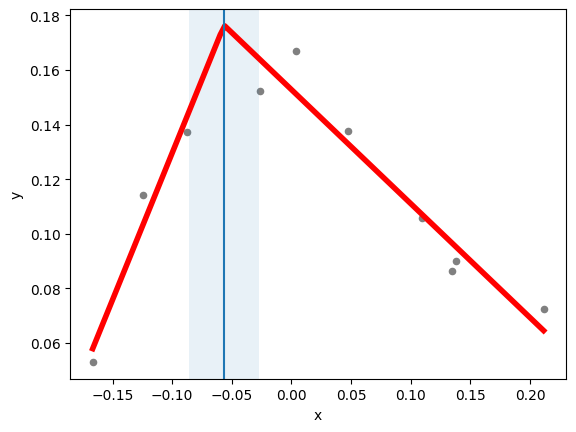

In [15]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit2.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit2.plot_fit(color="red", linewidth=4)
pw_fit2.plot_breakpoints()
pw_fit2.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")

plt.show()
plt.close()

# Case 3

In [16]:
df3 = pd.read_csv('j.nanoen.2019.01.017_1.csv',header=None, names=["x", "y"])
df3

,x,y
0,-0.366600,-7.059288
1,-0.561846,-6.802344
2,-0.428929,-5.902685
3,-0.268223,-5.298441
4,-0.263989,-5.176458
5,-0.097313,-3.596959
6,-0.087430,-3.309431
7,-0.095771,-3.231254
8,-0.084539,-3.056880
9,-0.141718,-2.979767


In [17]:
ms_3 = piecewise_regression.ModelSelection(df3['x'].values, df3['y'].values, max_breakpoints=3)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     23.699         True       48.513 
1                     2.6445         True       11.749 
2                     8.5334         True       11.749 
3                     14.422         True       11.749 

Min BIC (Bayesian Information Criterion) suggests best model


In [18]:
pw_fit3 = piecewise_regression.Fit(df3["x"].values, df3["y"].values, n_breakpoints=1)
pw_fit3.summary()


                    Breakpoint Regression Results                     
No. Observations                       19
No. Model Parameters                    4
Degrees of Freedom                     15
Res. Sum of Squares               11.7487
Total Sum of Squares              51.8723
R Squared                        0.773507
Adjusted R Squared               0.708795
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               -2.36395        0.464      -5.0904      0.000133      -3.3538      -1.3741
alpha1               8.38691         1.66       5.0505      0.000144       4.8474       11.926
beta1                -15.391         2.38      -6.4628             -      -20.467      -10.315
breakpoint1       -0.0708953       0.0527            -             -     -0.18318     0.041386
-----------------

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       19\nNo. Model Parameters                    4\nDegrees of Freedom                     15\nRes. Sum of Squares               11.7487\nTotal Sum of Squares              51.8723\nR Squared                        0.773507\nAdjusted R Squared               0.708795\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst               -2.36395        0.464      -5.0904      0.000133      -3.3

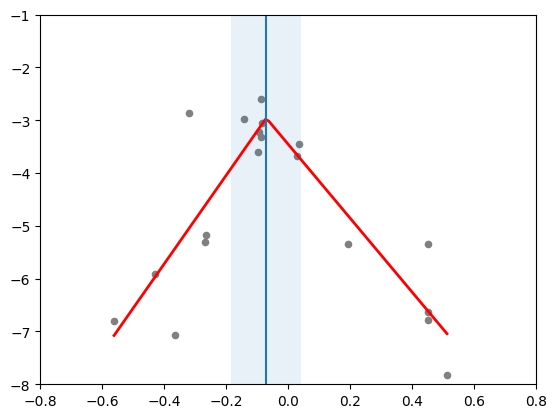

In [19]:
import numpy as np
from matplotlib import rc


# Plot the data, fit, breakpoints and confidence intervals
pw_fit3.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit3.plot_fit(color="red", linewidth=2)
pw_fit3.plot_breakpoints()
pw_fit3.plot_breakpoint_confidence_intervals()
plt.xlabel("")
plt.ylabel("")
plt.ylim(-8, -1)
plt.xlim(-0.8, 0.8)


plt.savefig("electro.svg",dpi = 600)
plt.show()

# Case 4

In [20]:
df4 = pd.read_csv('science.aad4998_HER1.csv',header=None, names=["x", "y"])
df4

,x,y
0,-0.320566,0.133209
1,-0.563902,0.181297
2,-0.273799,0.297674
3,-0.199246,0.384615
4,-0.237972,0.405896
5,-0.121228,0.706135
6,-0.091726,0.734756
7,-0.026561,0.766513
8,-0.026669,0.696457
9,-0.028330,0.625341


In [21]:
ms_4 = piecewise_regression.ModelSelection(df4['x'].values, df4['y'].values, max_breakpoints=3)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -35.065         True      0.78458 
1                    -51.133         True      0.17079 
2                    -55.015         True     0.088781 
3                    -30.792         True      0.34357 

Min BIC (Bayesian Information Criterion) suggests best model


In [22]:
pw_fit4 = piecewise_regression.Fit(df4["x"].values, df4["y"].values, n_breakpoints=1)
pw_fit4.summary()


                    Breakpoint Regression Results                     
No. Observations                       14
No. Model Parameters                    4
Degrees of Freedom                     10
Res. Sum of Squares              0.170788
Total Sum of Squares             0.784607
R Squared                        0.782327
Adjusted R Squared               0.685584
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               0.723991        0.101       7.1881      2.97e-05      0.49957      0.94841
alpha1               1.22998         0.34       3.6201       0.00469      0.47295        1.987
beta1               -2.45224        0.431      -5.6898             -      -3.4125      -1.4919
breakpoint1       -0.0290802        0.046            -             -     -0.13155     0.073389
-----------------

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       14\nNo. Model Parameters                    4\nDegrees of Freedom                     10\nRes. Sum of Squares              0.170788\nTotal Sum of Squares             0.784607\nR Squared                        0.782327\nAdjusted R Squared               0.685584\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst               0.723991        0.101       7.1881      2.97e-05      0.49

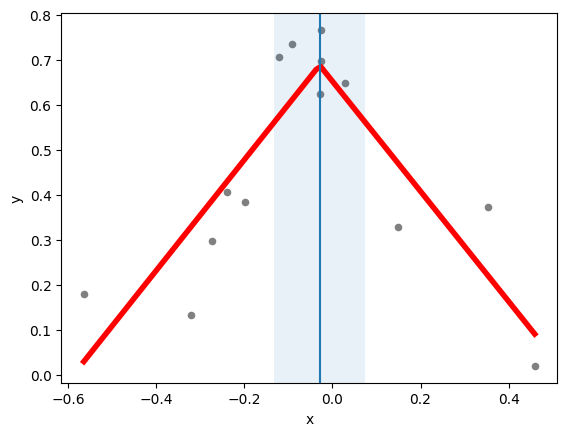

In [23]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit4.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit4.plot_fit(color="red", linewidth=4)
pw_fit4.plot_breakpoints()
pw_fit4.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()


# Case 5

In [24]:
df5 = pd.read_csv('iSCIENCE_OER.csv',header=None, names=["x", "y"])
df5

,x,y
0,15.481651,-1.634145
1,46.444954,-1.424279
2,25.802752,-1.424702
3,47.133028,-1.130932
4,36.811927,-1.180374
5,22.706422,-1.199125
6,7.912844,-1.055839
7,59.862385,-1.038363
8,71.903670,-0.939654
9,97.706422,-0.512458


In [25]:
ms_5 = piecewise_regression.ModelSelection(df5['x'].values, df5['y'].values, max_breakpoints=2,max_iterations=100,tolerance=1e-03)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -31.816         True       1.2535 
1                                   False              
2                    -29.085         True      0.73042 

Min BIC (Bayesian Information Criterion) suggests best model


In [26]:
ms_5.models

In [27]:
pw_fit5 = piecewise_regression.Fit(df5["x"].values, df5["y"].values, n_breakpoints=2,tolerance=1e-05,max_iterations=100)
pw_fit5.summary()


                    Breakpoint Regression Results                     
No. Observations                       15
No. Model Parameters                    6
Degrees of Freedom                      9
Res. Sum of Squares              0.730418
Total Sum of Squares              1.29353
R Squared                        0.435331
Adjusted R Squared               0.011828
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const             -0.0338604        0.166     -0.20443         0.843     -0.40854      0.34082
alpha1             -0.129154       0.0172      -7.5216      3.61e-05       -0.168    -0.090311
beta1               0.138575         0.02        6.945             -     0.093438      0.18371
beta2             -0.0109893      0.00546      -2.0143             -    -0.023331    0.0013524
breakpoint1      

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       15\nNo. Model Parameters                    6\nDegrees of Freedom                      9\nRes. Sum of Squares              0.730418\nTotal Sum of Squares              1.29353\nR Squared                        0.435331\nAdjusted R Squared               0.011828\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst             -0.0338604        0.166     -0.20443         0.843     -0.40

In [28]:
pw5_results = pw_fit5.get_results()
pw5_estimates = pw5_results["estimates"]
pw5_estimates

{'const': {'estimate': -0.03386035404235568,
  'se': 0.1656291407695979,
  'confidence_interval': (-0.4085395011929375, 0.3408187931082262),
  't_stat': -0.20443476241573866,
  'p_t': 0.8425620895863964},
 'beta1': {'estimate': 0.1385747968014118,
  'se': 0.0199531516665631,
  'confidence_interval': (0.09343763183963874, 0.18371196176318486),
  't_stat': 6.945007942461107,
  'p_t': '-'},
 'breakpoint1': {'estimate': 11.521880126642495,
  'se': 2.5831987654289694,
  'confidence_interval': (5.678278536643665, 17.365481716641327),
  't_stat': '-',
  'p_t': '-'},
 'beta2': {'estimate': -0.010989320029067528,
  'se': 0.005455747870510943,
  'confidence_interval': (-0.02333107915245277, 0.0013524390943177138),
  't_stat': -2.0142646416023533,
  'p_t': '-'},
 'breakpoint2': {'estimate': 81.96310613995874,
  'se': 25.96922370838708,
  'confidence_interval': (23.21664071720773, 140.70957156270975),
  't_stat': '-',
  'p_t': '-'},
 'alpha1': {'estimate': -0.12915435555454313,
  'se': 0.017171030

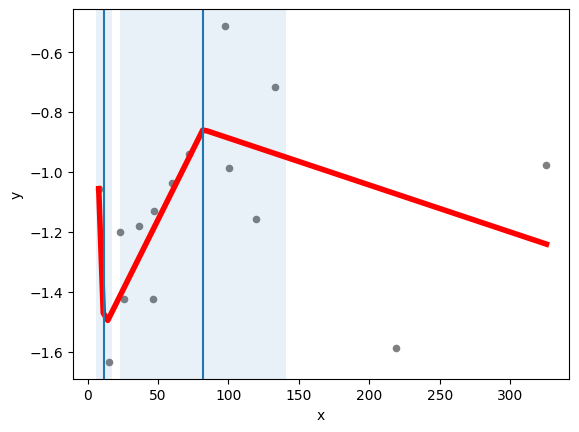

In [29]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit5.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit5.plot_fit(color="red", linewidth=4)
pw_fit5.plot_breakpoints()
pw_fit5.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

# Case 6 Homogeneous

In [30]:
df6 = pd.read_csv('doi.org_10.1039_C5SC02910D.csv',header=None, names=["x", "y"])
df6

,x,y
0,-66.536541,-9.753641
1,-55.195754,-6.478916
2,-57.072222,-0.723350
3,-53.804772,-2.370915
4,-50.540782,-2.237655
5,-47.741784,-2.788795
6,-44.145087,-13.888792
7,-43.234002,-2.793941
8,-40.743756,-4.440620
9,-38.573441,-1.429398


In [31]:
ms_6 = piecewise_regression.ModelSelection(df6['x'].values, df6['y'].values, max_breakpoints=3)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     99.351         True       1028.0 
1                     81.569         True       390.18 
2                     87.218         True       378.07 
3                     92.871         True       366.39 

Min BIC (Bayesian Information Criterion) suggests best model


In [32]:
pw_fit6 = piecewise_regression.Fit(df6["x"].values, df6["y"].values, n_breakpoints=1)
pw_fit6.summary()


                    Breakpoint Regression Results                     
No. Observations                       25
No. Model Parameters                    4
Degrees of Freedom                     21
Res. Sum of Squares               390.183
Total Sum of Squares              2310.83
R Squared                        0.831150
Adjusted R Squared               0.797380
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const             -0.0119871         3.62   -0.0033122         0.997      -7.5383       7.5144
alpha1              0.100171        0.082       1.2219         0.235     -0.07031      0.27065
beta1              -0.867282        0.152        -5.71             -      -1.1832     -0.55141
breakpoint1         -8.32123         5.08            -             -      -18.879       2.2366
-----------------

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       25\nNo. Model Parameters                    4\nDegrees of Freedom                     21\nRes. Sum of Squares               390.183\nTotal Sum of Squares              2310.83\nR Squared                        0.831150\nAdjusted R Squared               0.797380\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst             -0.0119871         3.62   -0.0033122         0.997      -7.5

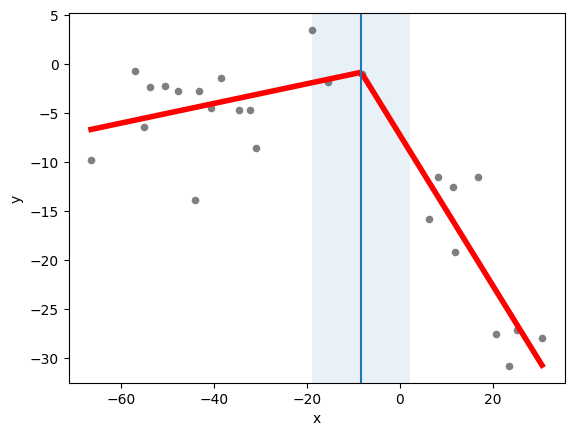

In [33]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit6.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit6.plot_fit(color="red", linewidth=4)
pw_fit6.plot_breakpoints()
pw_fit6.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

In [34]:
df7 = pd.read_csv('C5SC02910D_2.csv',header=None, names=["x", "y"])
df7

,x,y
0,-66.468916,-2.436078
1,-55.597757,2.542972
2,-56.668095,2.199197
3,-54.189417,5.626886
4,-51.322527,4.774228
5,-47.763714,7.175841
6,-45.108687,10.946212
7,-42.440189,12.833037
8,-41.167785,9.923635
9,-34.740857,11.301358


In [35]:
ms_7 = piecewise_regression.ModelSelection(df7['x'].values, df7['y'].values, max_breakpoints=3)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     133.13         True       2928.6 
1                     60.047         True       153.17 
2                     61.652         True       127.34 
3                     67.262         True       122.79 

Min BIC (Bayesian Information Criterion) suggests best model


In [36]:
pw_fit7 = piecewise_regression.Fit(df7["x"].values, df7["y"].values, n_breakpoints=2)
pw_fit7.summary()


                    Breakpoint Regression Results                     
No. Observations                       27
No. Model Parameters                    6
Degrees of Freedom                     21
Res. Sum of Squares               127.336
Total Sum of Squares              10302.8
R Squared                        0.987641
Adjusted R Squared               0.983933
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                35.5693          5.6       6.3504      2.69e-06       23.921       47.218
alpha1              0.578516        0.108       5.3451      2.67e-05      0.35343       0.8036
beta1              -0.613613        0.156      -3.9293             -     -0.93837     -0.28885
beta2              -0.955235        0.121      -7.8639             -      -1.2078     -0.70262
breakpoint1      

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       27\nNo. Model Parameters                    6\nDegrees of Freedom                     21\nRes. Sum of Squares               127.336\nTotal Sum of Squares              10302.8\nR Squared                        0.987641\nAdjusted R Squared               0.983933\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst                35.5693          5.6       6.3504      2.69e-06       23.

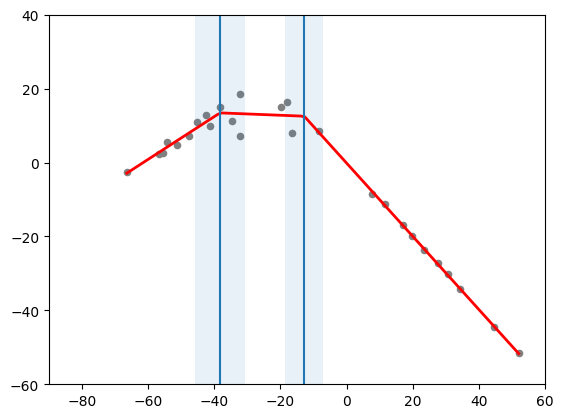

In [37]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit7.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit7.plot_fit(color="red", linewidth=2)
pw_fit7.plot_breakpoints()
pw_fit7.plot_breakpoint_confidence_intervals()
plt.xlabel("")
plt.ylabel("")

plt.ylim(-60, 40)
plt.xlim(-90, 60)

plt.savefig("HOMO.svg",dpi = 600)
plt.show()


In [38]:
df8 = pd.read_csv('Homocatalysis_exp.csv',header=None, names=["x", "y"])
df8

,x,y
0,2.497413,-1.132804
1,5.610762,-0.805795
2,8.879200,-0.834771
3,10.280511,-0.492584
4,11.836909,-0.506382
...,...,...
58,16.810210,94.839600
59,17.416764,84.550535
60,19.909210,85.946878
61,32.517144,86.544326


In [39]:
ms_8 = piecewise_regression.ModelSelection(df8['x'].values, df8['y'].values, max_breakpoints=3)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     435.99         True   5.5943e+04 
1                     442.85         True   5.4692e+04 
2                     444.75         True   4.9421e+04 
3                     452.14         True   4.8724e+04 

Min BIC (Bayesian Information Criterion) suggests best model


In [40]:
pw_fit8 = piecewise_regression.Fit(df8["x"].values, df8["y"].values, n_breakpoints=1)
pw_fit8.summary()


                    Breakpoint Regression Results                     
No. Observations                       63
No. Model Parameters                    4
Degrees of Freedom                     59
Res. Sum of Squares               54692.1
Total Sum of Squares              60566.0
R Squared                        0.096983
Adjusted R Squared               0.034706
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               -18.0351         15.6      -1.1568         0.252      -49.232       13.162
alpha1               3.15844        0.988       3.1955       0.00224       1.1807       5.1362
beta1               -2.51232         2.01      -1.2517             -      -6.5287       1.5041
breakpoint1          13.8042         11.3            -             -      -8.8865       36.495
-----------------

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       63\nNo. Model Parameters                    4\nDegrees of Freedom                     59\nRes. Sum of Squares               54692.1\nTotal Sum of Squares              60566.0\nR Squared                        0.096983\nAdjusted R Squared               0.034706\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst               -18.0351         15.6      -1.1568         0.252      -49.

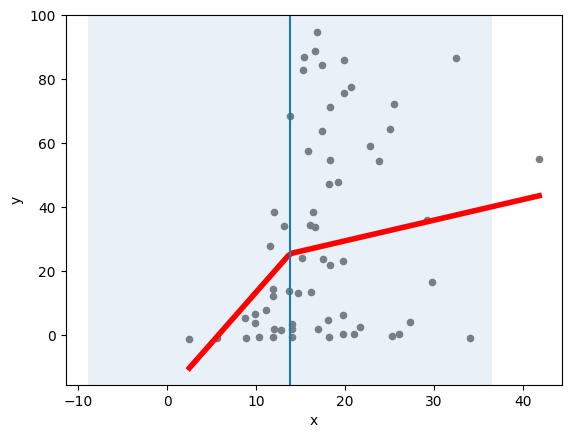

In [41]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit8.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit8.plot_fit(color="red", linewidth=4)
pw_fit8.plot_breakpoints()
pw_fit8.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

# Biocatalysis

In [42]:
df10 = pd.read_csv('Bioplot_Green.csv',header=None, names=["x", "y"])
df10

,x,y
0,-3.603913,0.149246
1,-2.910203,0.179397
2,-1.982764,0.180905
3,-1.597067,0.192965
4,-2.101231,0.220101
5,-1.888962,0.224623
6,-0.017382,0.268342
7,0.408613,0.254774
8,2.054427,0.203518
9,2.887578,0.168844


In [43]:
ms_10 = piecewise_regression.ModelSelection(df10['x'].values, df10['y'].values, max_breakpoints=3)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -79.186         True     0.019823 
1                    -93.505         True    0.0044405 
2                    -88.357         True    0.0044467 
3                                   False              

Min BIC (Bayesian Information Criterion) suggests best model


In [45]:
pw_fit10 = piecewise_regression.Fit(df10["x"].values, df10["y"].values, n_breakpoints=1)
pw_fit10.summary()


                    Breakpoint Regression Results                     
No. Observations                       13
No. Model Parameters                    4
Degrees of Freedom                      9
Res. Sum of Squares            0.00444047
Total Sum of Squares            0.0222956
R Squared                        0.800836
Adjusted R Squared               0.701254
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               0.256293       0.0318       8.0529       2.1e-05       0.1843      0.32829
alpha1             0.0277278        0.013       2.1318        0.0618   -0.0016959     0.057152
beta1             -0.0591909       0.0141      -4.1886             -    -0.091158    -0.027223
breakpoint1        0.0482646        0.602            -             -      -1.3133       1.4099
-----------------

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       13\nNo. Model Parameters                    4\nDegrees of Freedom                      9\nRes. Sum of Squares            0.00444047\nTotal Sum of Squares            0.0222956\nR Squared                        0.800836\nAdjusted R Squared               0.701254\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst               0.256293       0.0318       8.0529       2.1e-05       0.1

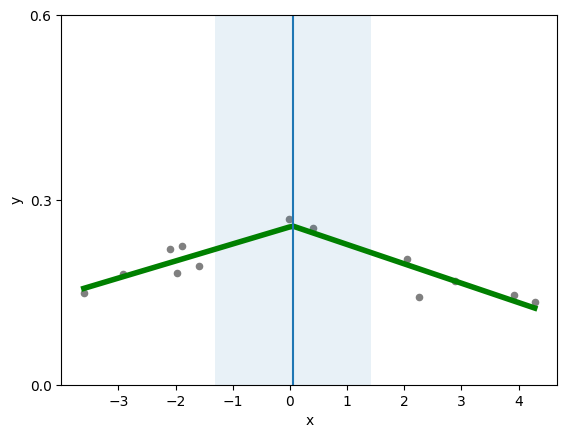

In [46]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit10.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit10.plot_fit(color="green", linewidth=4)
pw_fit10.plot_breakpoints()
pw_fit10.plot_breakpoint_confidence_intervals()
plt.yticks([0,0.3,0.6])
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

In [47]:
df9 = pd.read_csv('Bioplot_Blue.csv',header=None, names=["x", "y"])
df9

,x,y
0,-3.663276,0.165704
1,-2.913199,0.186555
2,-2.538287,0.193532
3,-2.095992,0.235007
4,-1.874021,0.278158
5,0.442770,0.352796
6,2.118727,0.380743
7,2.912819,0.399880
8,3.903612,0.374231
9,4.300120,0.369144


In [48]:
ms_9 = piecewise_regression.ModelSelection(df9['x'].values, df9['y'].values, max_breakpoints=2)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -68.341         True     0.014251 
1                    -69.008         True     0.008673 
2                    -66.127         True    0.0072873 

Min BIC (Bayesian Information Criterion) suggests best model


In [49]:
pw_fit9 = piecewise_regression.Fit(df9["x"].values, df9["y"].values, n_breakpoints=1)
pw_fit9.summary()


                    Breakpoint Regression Results                     
No. Observations                       11
No. Model Parameters                    4
Degrees of Freedom                      7
Res. Sum of Squares            0.00867304
Total Sum of Squares            0.0761556
R Squared                        0.886114
Adjusted R Squared               0.810190
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               0.362224       0.0668       5.4209      0.000986      0.20422      0.52023
alpha1              0.057484       0.0248       2.3165        0.0537    -0.001194      0.11616
beta1             -0.0498866       0.0273      -1.8284             -      -0.1144     0.014631
breakpoint1        -0.441301         1.36            -             -      -3.6599       2.7773
-----------------

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       11\nNo. Model Parameters                    4\nDegrees of Freedom                      7\nRes. Sum of Squares            0.00867304\nTotal Sum of Squares            0.0761556\nR Squared                        0.886114\nAdjusted R Squared               0.810190\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst               0.362224       0.0668       5.4209      0.000986      0.20

In [ ]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit9.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit9.plot_fit(color="blue", linewidth=2)
pw_fit9.plot_breakpoints()
pw_fit9.plot_breakpoint_confidence_intervals()
plt.xticks([-4,-2,0,2,4,6])
plt.yticks([0,0.2,0.4,0.6])
plt.xlabel("")
plt.ylabel("")

plt.savefig("bio.svg",dpi = 600)
plt.show()
